# Final Project: House Price Prediction
## Corpus Christi Team
### Step 5 (Machine Learning Model for House Prediction)

In [1]:
# Import general use libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import glob
import math
import csv
import warnings
from time import sleep
from tqdm import tqdm
from datetime import datetime as dt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Import ML related libraries
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import plot_importance
from shapash.explainer.smart_explainer import SmartExplainer

# Import database related libraries
import psycopg2
import psycopg2.extras
from config import db as dbpwd

#### Read the input data for ML (Joined Table in PostGreSQL DB)

In [2]:
# Read from DB
hostname = 'localhost'
database = 'real_estate_data_test'
username = 'postgres'
pwd = dbpwd
port_id = 5432
db_table_name = 'htx_joined_data_house_crime'
conn = None
cur = None

with psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(hostname, port_id, database, username, pwd)) as conn:
    sql = "select * from {};".format(db_table_name)
    df = pd.read_sql_query(sql, conn)

df

,zid,state,city,address,lat,lng,price,image,bedrooms,bathrooms,lotarea,constructedarea,zipcode,countyid,taxrate,hasgarage,haspool,hascooling,hasview,yearbuilt,stories,parkingspaces,annualhoi,annualhoa,schoolelemrating,schoolelemdist,schoolmidrating,schoolmiddist,schoolhighrating,schoolhighdist,priceincreased,pricediff,days,lotareasqft,avgschoolrating,avgschooldist,crimecount,crimepercentage
0,27541924,TX,Houston,"6602 Indian Lake Dr, Missouri City, TX 77489",29.603600,-95.485405,276000,https://photos.zillowstatic.com/fp/bc5a7196226...,3,2,8764.272000,3612.0,77489,2698,2.41,1,0,1,0,1971,2,2,1159,$400 annually,6,0.5,3,1.3,2,1.1,1,31000.0,1213,8764.272000,3.666667,0.966667,774.0,0.336866
1,27542111,TX,Houston,"6727 Castleview Ln, Missouri City, TX 77489",29.600388,-95.488210,220000,https://photos.zillowstatic.com/fp/1336380a837...,3,2,7884.360000,1270.0,77489,2698,2.41,1,0,1,0,1972,1,1,924,$144 annually,6,0.3,3,1.3,2,1.0,1,65100.0,503,7884.360000,3.666667,0.866667,774.0,0.336866
2,27542455,TX,Houston,"15902 Ridgerock Rd, Missouri City, TX 77489",29.595436,-95.485880,230000,https://photos.zillowstatic.com/fp/5603ce32232...,4,2,7148.196000,1765.0,77489,2698,2.41,1,0,1,0,1974,1,2,966,$250 annually,6,0.3,3,1.0,2,0.6,1,115275.0,5140,7148.196000,3.666667,0.633333,774.0,0.336866
3,27542890,TX,Houston,"15806 Blueridge Rd, Missouri City, TX 77489",29.597320,-95.492690,225000,https://photos.zillowstatic.com/fp/4d5e3792d33...,3,2,7731.900000,1444.0,77489,2698,2.41,1,0,1,0,1978,1,2,945,,6,0.1,3,1.4,2,1.0,1,56000.0,824,7731.900000,3.666667,0.833333,774.0,0.336866
4,27543383,TX,Houston,"6919 Rockergate Dr, Missouri City, TX 77489",29.592060,-95.489050,246500,https://maps.googleapis.com/maps/api/staticmap...,3,2,8062.956000,1738.0,77489,2698,2.41,1,0,1,0,1978,1,2,1035,$144 annually,6,0.3,3,1.0,2,0.6,1,41500.0,6810,8062.956000,3.666667,0.633333,774.0,0.336866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,2125126583,TX,Houston,"627 W 25th St, Houston, TX 77008",29.808900,-95.408710,669900,https://photos.zillowstatic.com/fp/0e126fa6bb3...,3,3,3275.000000,2576.0,77008,1090,2.29,1,0,1,0,2022,2,2,2814,,5,0.3,5,0.7,5,1.3,1,404900.0,3993,3275.000000,5.000000,0.766667,3046.0,1.325702
4496,2125214802,TX,Houston,"4608 Inker St, Houston, TX 77007",29.775753,-95.407600,519000,https://photos.zillowstatic.com/fp/7d8db8b600e...,3,4,2330.460000,2513.0,77007,1090,2.29,1,0,1,0,2006,3,2,2180,,8,1.2,6,1.6,5,1.5,1,522400.0,4145,2330.460000,6.333333,1.433333,4647.0,2.022501
4497,2127408520,TX,Houston,"3570 Noah St, Houston, TX 77021",29.685492,-95.371700,550000,https://photos.zillowstatic.com/fp/17b624955d6...,1,2,0.344353,5160.0,77021,1090,2.29,1,0,1,0,1952,1,2,2310,,2,0.3,3,0.6,2,2.5,1,375000.0,4219,14999.999997,2.333333,1.133333,4588.0,1.996823
4498,2134060336,TX,Houston,"5234 Cornish St STE A, Houston, TX 77007",29.778660,-95.415340,450000,https://photos.zillowstatic.com/fp/06157f370ad...,3,4,2051.676000,2148.0,77007,1090,2.29,1,0,1,0,2007,3,2,1890,,4,1.0,6,2.0,3,2.7,0,0.0,0,2051.676000,4.333333,1.900000,4647.0,2.022501


#### Do some additional ML conditioning based on previous testing

In [3]:
# Based on previous testing, remove low-weight and unnecessary features
df = df.drop(['zid', 'address', 'lotarea', 'image', 'countyid', 'taxrate', 'annualhoa', 'annualhoi', 'state', 'city', 'days', 'pricediff', 'priceincreased', 'lat', 'lng', 'schoolelemrating', 'schoolmidrating', 'schoolhighrating', 'schoolelemdist', 'schoolmiddist', 'schoolhighdist', 'hasview', 'hascooling', 'haspool', 'hasgarage', 'stories', 'parkingspaces', 'crimecount'], axis=1)

#### Perform basic QC on the input DF

In [4]:
# Reaplce all null values by the average of the column values
df = df.fillna(df.mean())

#### Save the DF conditioned for ML

In [24]:
ou_name = '05_ML_from_DB_'+ db_table_name + '.csv'

# Create output directory if it does not exist
ou_path = './data/'
os.makedirs(ou_path, exist_ok=True)

# Save to a csv file
df.to_csv(f'{ou_path}{ou_name}', index=False)

In [6]:
# Check if there are any null values
df.isnull().sum()

price              0
bedrooms           0
bathrooms          0
constructedarea    0
zipcode            0
yearbuilt          0
lotareasqft        0
avgschoolrating    0
avgschooldist      0
crimepercentage    0
dtype: int64

In [7]:
# Get statistics
df.describe()

,price,bedrooms,bathrooms,constructedarea,zipcode,yearbuilt,lotareasqft,avgschoolrating,avgschooldist,crimepercentage
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,401480.002667,3.393556,2.830667,2158.662015,77070.912667,1993.300222,7776.873718,108.415534,105.570933,1.027040
std,157007.688575,0.724881,0.887162,711.170309,81.504576,28.878517,22153.124331,304.181863,305.144595,0.699221
min,200000.000000,0.000000,0.000000,0.000000,77003.000000,1888.000000,0.000000,2.000000,0.166667,0.000435
25%,280000.000000,3.000000,2.000000,1680.750000,77022.000000,1970.000000,4225.757000,3.333333,0.933333,0.356886
50%,364000.000000,3.000000,3.000000,2020.000000,77057.000000,2003.000000,6993.558000,4.333333,1.333333,1.130285
75%,469990.000000,4.000000,3.000000,2528.250000,77084.000000,2022.000000,8160.000000,6.000000,1.966667,1.481514
max,900000.000000,10.000000,7.000000,6793.000000,77598.000000,2023.000000,980100.000000,999.000000,999.000000,3.719017


In [8]:
# Print the DF that is input to the ML algorithm
df

,price,bedrooms,bathrooms,constructedarea,zipcode,yearbuilt,lotareasqft,avgschoolrating,avgschooldist,crimepercentage
0,276000,3,2,3612.0,77489,1971,8764.272000,3.666667,0.966667,0.336866
1,220000,3,2,1270.0,77489,1972,7884.360000,3.666667,0.866667,0.336866
2,230000,4,2,1765.0,77489,1974,7148.196000,3.666667,0.633333,0.336866
3,225000,3,2,1444.0,77489,1978,7731.900000,3.666667,0.833333,0.336866
4,246500,3,2,1738.0,77489,1978,8062.956000,3.666667,0.633333,0.336866
...,...,...,...,...,...,...,...,...,...,...
4495,669900,3,3,2576.0,77008,2022,3275.000000,5.000000,0.766667,1.325702
4496,519000,3,4,2513.0,77007,2006,2330.460000,6.333333,1.433333,2.022501
4497,550000,1,2,5160.0,77021,1952,14999.999997,2.333333,1.133333,1.996823
4498,450000,3,4,2148.0,77007,2007,2051.676000,4.333333,1.900000,2.022501


<AxesSubplot:>

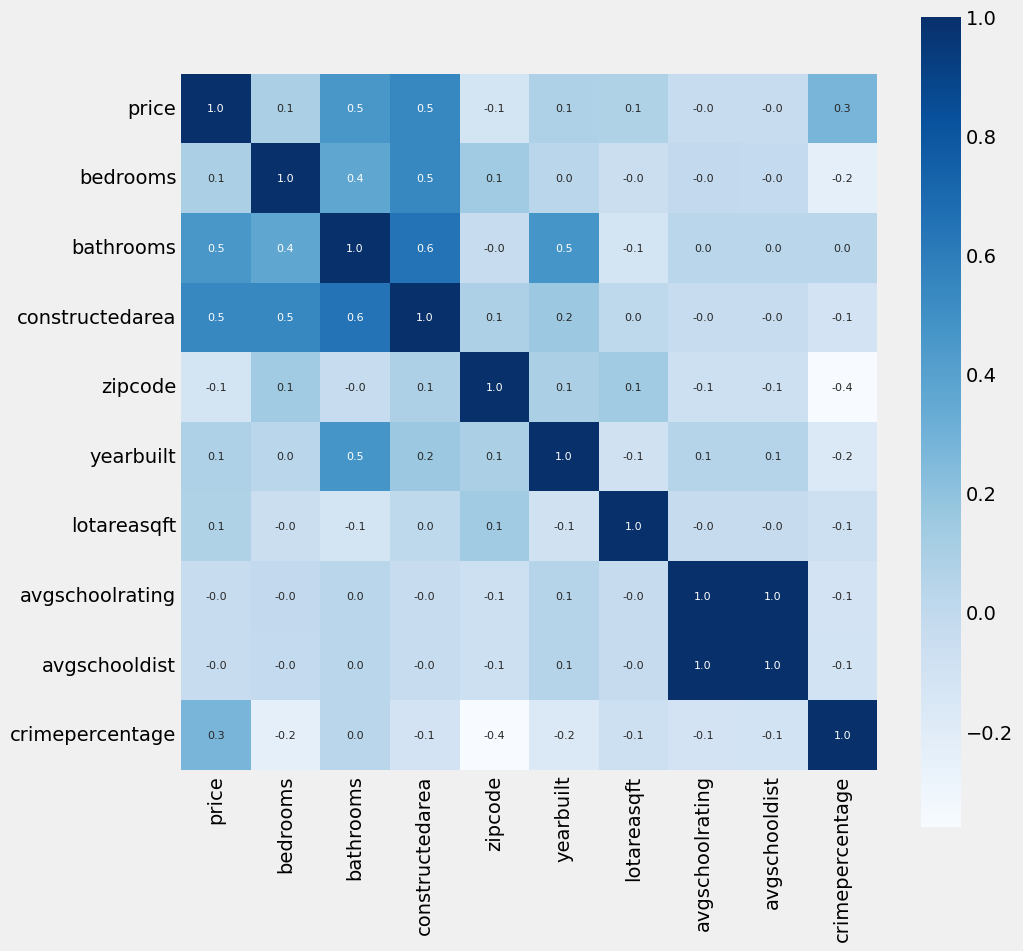

In [9]:
# Heat map
# A heat map shows the correlation between the input data columns
# There are 2 types of correlation:
# Positive: As the magnitude of a feature increases, the magnitude of a correlated feature increases
# Negative: As the magnitude of a feature increases, the magnitude of a correlated feature decreases
correlation = df.corr()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

#### Get the features and the target column

In [10]:
# Create a new DataFrame that holds only the cryptocurrencies names.
# X = Features, y = target
X = df.drop('price', axis=1)
y = df[["price"]]

#### Split the data for training and testing

In [11]:
# Use 20% of data for testing. Use a random_state = 2 to be able to reproduce the splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
print(X.shape, X_train.shape, X_test.shape)

(4500, 9) (3600, 9) (900, 9)


#### Model Training

In [12]:
# Load the model (XGBoost Regressor)
model = XGBRegressor()

# Train the model with the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

#### Make predictions using the test data

In [13]:
y_pred = model.predict(X_test)

# Calculate the R squared error
error_r2 = metrics.r2_score(y_test, y_pred)

# Calculate the mean absolute error
error_ma = metrics.mean_absolute_error(y_test, y_pred)

print(f'R squared error: {error_r2} (should be close to 1)')

R squared error: 0.7971174609250198 (should be close to 1)


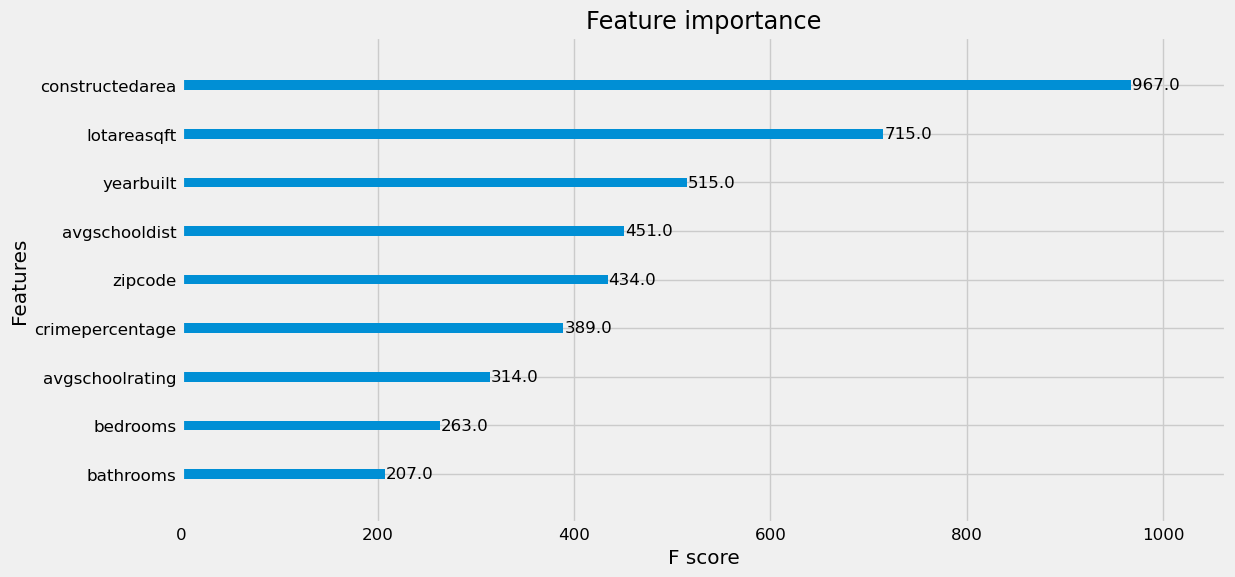

In [14]:
# Plot the features importance
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12,6))
plot_importance(model, ax=ax)
plt.show();

In [15]:
# Display the actual price vs the predicted price
y_test_df = y_test.reset_index(drop=True)
y_test_df = y_test_df.rename(columns = {'Price':'Actual_Price'})

y_pred_df = pd.DataFrame(y_pred, columns = ['Predicted_Price'])
y_pred_df = y_pred_df['Predicted_Price'].apply(np.ceil).astype('int')

# Display the actual and the predicted prices side by side
df_prices = pd.concat([y_test_df, y_pred_df], axis=1)
df_prices

,price,Predicted_Price
0,280000,324861
1,260000,289051
2,409990,465842
3,825000,784156
4,599900,625457
...,...,...
895,474500,369318
896,249500,220773
897,399900,356492
898,599000,546940


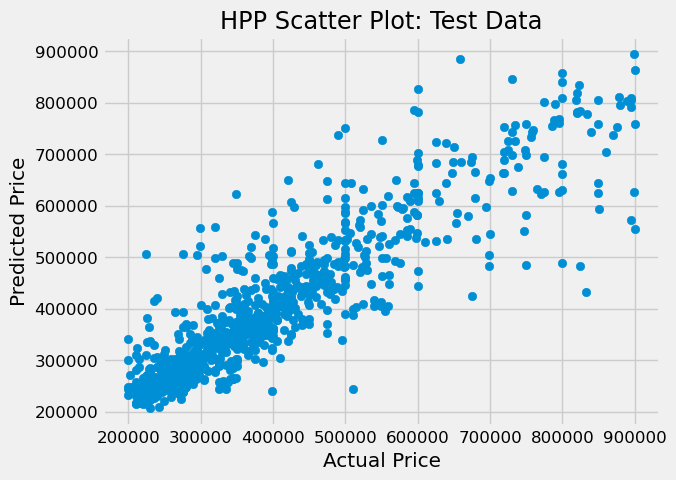

In [16]:
# Scatter Plot using test data
plt.scatter(y_test_df, y_pred_df)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('HPP Scatter Plot: Test Data')
plt.show()

### Understanding the model with Shapash
#### If not installed, run the following command in your conda environment
!pip install shapash

In [17]:
# Initialize shapash with the ML model
xpl = SmartExplainer(model)

In [18]:
# Condition X_test and y_pred for Shapash
# Display the actual price vs the predicted price
temp = X_test.reset_index(drop=True)
sp_X_test = temp.rename(columns = {'Price':'Price'})
del(temp)

temp = pd.DataFrame(y_pred, columns = ['Price'])
sp_y_pred = temp['Price'].apply(np.ceil).astype('int')
del(temp)

temp = y_test.reset_index(drop=True)
sp_y_target = temp.rename(columns = {'Price':'Price'})
del(temp)

In [19]:
# Compile shapash
xpl.compile(x=sp_X_test, y_pred=sp_y_pred, y_target=sp_y_target)

In [20]:
app = xpl.run_app(title_story='House_Price_Prediction')

Dash is running on http://0.0.0.0:8050/



INFO:root:Your Shapash application run on http://Oscar:8050/
INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8050/

INFO:root:Use the method .kill() to down your app.


 * Serving Flask app 'shapash.webapp.smart_app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [21]:
# Plot a summary with the contribution of the features
summary_df = xpl.to_pandas(max_contrib=14) #Number of max features to show in summary
summary_df.head()

INFO:werkzeug: * Running on http://192.168.1.228:8050/ (Press CTRL+C to quit)


,Price,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3,feature_4,value_4,contribution_4,feature_5,value_5,contribution_5,feature_6,value_6,contribution_6,feature_7,value_7,contribution_7,feature_8,value_8,contribution_8,feature_9,value_9,contribution_9
0,324861,constructedarea,2836.0,56830.933594,yearbuilt,1978.0,-46151.417969,crimepercentage,0.336866,-41113.113281,zipcode,77489.0,-28777.732422,avgschoolrating,4.0,-9501.94043,lotareasqft,7200.468,6135.602539,bathrooms,3.0,-6059.800293,avgschooldist,1.766667,-3630.750488,bedrooms,4.0,-2999.072998
1,289051,constructedarea,1500.0,-71304.117188,avgschoolrating,3.666667,-25636.34375,crimepercentage,1.996823,9250.095703,lotareasqft,7775.70134,-8297.004883,zipcode,77021.0,-7257.268066,bathrooms,2.0,-5467.506836,bedrooms,4.0,-3701.158203,yearbuilt,1946.0,3479.894287,avgschooldist,1.166667,-2143.889404
2,465842,zipcode,77011.0,60530.785156,yearbuilt,2022.0,28425.109375,constructedarea,1926.0,-23429.330078,lotareasqft,10001.376,21068.125,crimepercentage,0.671991,-20525.369141,avgschoolrating,3.666667,-16376.68457,avgschooldist,0.666667,12705.226562,bedrooms,3.0,3441.32959,bathrooms,3.0,-125.001762
3,784156,constructedarea,3530.0,233819.234375,crimepercentage,0.889605,91476.507812,yearbuilt,1978.0,-33739.035156,lotareasqft,8637.948,20413.103516,bathrooms,4.0,20149.203125,avgschooldist,0.6,17531.267578,bedrooms,3.0,15993.478516,avgschoolrating,5.333333,15803.821289,zipcode,77079.0,2579.629883
4,625457,zipcode,77004.0,87817.851562,constructedarea,2610.0,80603.03125,crimepercentage,2.457729,60711.710938,yearbuilt,2023.0,46227.816406,avgschoolrating,4.0,-31355.521484,bathrooms,4.0,-12746.954102,lotareasqft,3249.576,-5352.310059,avgschooldist,2.0,-4594.095215,bedrooms,3.0,4017.614014


In [22]:
# Kill the dashboard (Run when done)
#app.kill